# Assignment 1: AutoEncoders
### Author: Jacopo Raffi

In [1]:
import torch
import numpy
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets
import matplotlib.pyplot as plt
import os
import wandb
import numpy
import torch.utils.data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.environ['WANDB_NOTEBOOK_NAME'] = 'ISPR_Midterm3_Assignment1_JacopoRaffi.ipynb'
wandb.login()

/home/jacopo/hlt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: raffijacopo (jacopo-raffi). Use `wandb login --relogin` to force relogin


True

## Data Splitting

In [2]:
train_size = 0.8
val_size = 0.2
generator_gpu = torch.Generator(device=device)
generator = torch.Generator()

train_data  = torchvision.datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=False)
test_data = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=False)

data_size = len(train_data)

train_set, val_set = torch.utils.data.random_split(train_data, [int(train_size*data_size), int(val_size*data_size)], generator=generator)

len(train_set), len(val_set)

(48000, 12000)

In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

### AutoEncoders type

In [4]:
def contractive_loss_function(base_loss, out_e, x, lamda):
    
    out_e.backward(gradient = torch.ones(out_e.size()).to(device), retain_graph=True)    
    # Frobenious norm, the square root of sum of all elements (square value) in a jacobian matrix 
    # loss2 = torch.sqrt(torch.sum(torch.pow(x.grad,2)))
    loss2 = torch.linalg.norm(x.grad)
    x.grad.data.zero_()
    loss = base_loss + (lamda*loss2) 
    return loss 

def add_noise(img_tensor, std=0.4):
    return (img_tensor + torch.randn(img_tensor.size(), generator=generator_gpu, device=device) * std)

## AutoEncoder Architecture

In [5]:
class ConvAE(nn.Module):
    def __init__(self, input_size = 28, hidden_size:int = 16, latent_size:int = 32, kernel_size:int = 3):
        super(ConvAE, self).__init__()

        linear_dim = (hidden_size) * (input_size//4) * (input_size//4)
        pad = (kernel_size - 1) // 2

        self.encoder = nn.Sequential(nn.Conv2d(1, hidden_size//2, kernel_size=kernel_size, padding=pad),
                                     nn.ReLU(), 
                                     nn.MaxPool2d(2, 2),
                                     nn.Conv2d(hidden_size//2, hidden_size, kernel_size=kernel_size, padding=pad),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, 2),
                                     nn.Flatten(),
                                     nn.Linear(linear_dim, latent_size),
                                     nn.ReLU()
                                     )
        
        self.decoder = nn.Sequential(nn.Linear(latent_size, linear_dim),
                                     nn.ReLU(), 
                                     nn.Unflatten(dim=1, unflattened_size=((hidden_size), (input_size//4), (input_size//4))),
                                     nn.ConvTranspose2d(hidden_size, hidden_size//2, kernel_size=2, stride=2), 
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(hidden_size//2, 1, kernel_size=2, stride=2), 
                                     nn.Sigmoid())

    def forward(self, x):
        x_e = self.encoder(x) 
    
        return self.decoder(x_e), x_e

### Auxilary Functions

In [6]:
def save_model(model:nn.Module, path:str):
    torch.save(model.state_dict(), path)


def load_model(path:str):
    model = ConvAE(hidden_size = 64, latent_size = 512)
    model.load_state_dict(torch.load(path))

    return model

def plot_img(model:nn.Module):
    j = 2
    x, _ = test_data[j]
    x = x.to(device)
    x_noisy = add_noise(x)
    
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    
    # clean input
    ax[0].imshow(x.to('cpu').numpy()[0], cmap='gray')
    out, _ = model(x.unsqueeze(0))
    ax[1].imshow(numpy.reshape((out.cpu().numpy()[0]), (28, 28)), cmap='gray')

    # noisy input
    ax[2].imshow(x_noisy.to('cpu').numpy()[0], cmap='gray')
    out, _ = model(x_noisy.unsqueeze(0))
    ax[3].imshow(numpy.reshape((out.cpu().numpy()[0]), (28, 28)), cmap='gray')

### Noisy image example

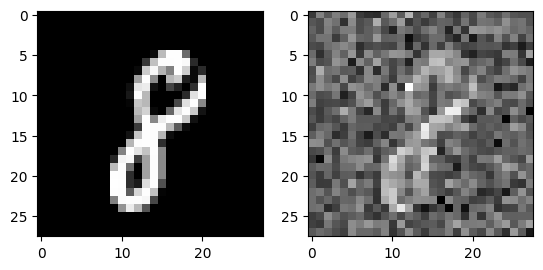

In [7]:
fig, ax = plt.subplots(1, 2)
j = 69
x, _ = train_set[j]
ax[0].imshow(x.numpy()[0], cmap='gray')
ax[1].imshow(add_noise(x.to(device)).cpu().numpy()[0], cmap='gray')

## Model Selection

In [8]:
class Configuration:
        def __init__(self, learning_rate, batch_size, epochs, weight_decay, hidden_size, autoencoder_type, latent_size, cae_penalization):
            self.learning_rate = learning_rate
            self.batch_size = batch_size
            self.epochs = epochs
            self.weight_decay = weight_decay
            self.hidden_size = hidden_size
            self.latent_size = latent_size
            self.autoencoder_type = autoencoder_type
            self.cae_penalization = cae_penalization
        
config_cae = Configuration(learning_rate = 0.003315,
                        batch_size = 1024,
                        epochs = 30,
                        weight_decay = 0.000003945,
                        hidden_size = 64,
                        latent_size=512,
                        autoencoder_type = 'cae',
                        cae_penalization = 1e-5)

config_dae = Configuration(learning_rate = 0.002004,
                        batch_size = 1024,
                        epochs = 30,
                        weight_decay = 0.000005557,
                        hidden_size = 64,
                        latent_size=512,
                        autoencoder_type = 'dae',
                        cae_penalization = 1e-5)

## Training

In [9]:
def train(config:Configuration=None, show_img:bool = False):
    #with wandb.init(config):
        #config = wandb.config
        model = ConvAE(hidden_size=config.hidden_size, latent_size=config.latent_size).to(device)
        min_val_loss = numpy.Inf

        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        criterion = torch.nn.MSELoss()
        val_criterion = torch.nn.L1Loss()

        epochs = config.epochs
        for epoch in range(epochs):
            model.train()
            tr_epoch_loss = 0
            for i, (input_img, _) in enumerate(train_loader):
                optimizer.zero_grad()

                input_img = input_img.to(device)

                if config.autoencoder_type == 'dae':
                    img_noisy = add_noise(input_img)
                    out, _ = model(img_noisy)
                
                    tr_loss = criterion(out, input_img)
                    tr_epoch_loss += tr_loss.item()

                else:
                    input_img.requires_grad_(True)
                    
                    out, out_e = model(input_img)
                    base_loss = criterion(out, input_img)
                    tr_loss = contractive_loss_function(base_loss=base_loss, out_e=out_e, x=input_img, lamda=config.cae_penalization)
                    tr_epoch_loss += base_loss.item()

                    input_img.requires_grad_(False)
                    optimizer.zero_grad()

                tr_loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                for input_img, _ in val_loader:
                    
                    input_img = input_img.to(device)
                    out, _ = model(input_img)
                        
                    val_loss = val_criterion(out, input_img)
                    mse_val_loss = criterion(out, input_img)

                l1_val_loss = val_loss.item()
                mse_val_loss = mse_val_loss.item()

                min_val_loss = min(min_val_loss, mse_val_loss)

                #wandb.log({'epoch': epoch+1, 'tr_loss':tr_epoch_loss/(i+1), 'L1_loss': l1_val_loss, 'mse_loss': mse_val_loss, 'min_loss': min_val_loss})

                print(f"epoch [{epoch + 1}/{epochs}], tr_loss: {tr_epoch_loss/(i+1):.4f}, L1_val_loss: {l1_val_loss:.4f}, MSE_val_loss: {mse_val_loss:.4f}")

                if show_img and (epoch % 5 == 0):
                    plot_img(model)
        
        return model

epoch [1/30], tr_loss: 0.0699, L1_val_loss: 0.1035, MSE_val_loss: 0.0456
epoch [2/30], tr_loss: 0.0323, L1_val_loss: 0.0603, MSE_val_loss: 0.0224
epoch [3/30], tr_loss: 0.0182, L1_val_loss: 0.0442, MSE_val_loss: 0.0148
epoch [4/30], tr_loss: 0.0132, L1_val_loss: 0.0369, MSE_val_loss: 0.0114
epoch [5/30], tr_loss: 0.0103, L1_val_loss: 0.0331, MSE_val_loss: 0.0097
epoch [6/30], tr_loss: 0.0089, L1_val_loss: 0.0302, MSE_val_loss: 0.0084
epoch [7/30], tr_loss: 0.0077, L1_val_loss: 0.0283, MSE_val_loss: 0.0075
epoch [8/30], tr_loss: 0.0072, L1_val_loss: 0.0272, MSE_val_loss: 0.0070
epoch [9/30], tr_loss: 0.0066, L1_val_loss: 0.0264, MSE_val_loss: 0.0066
epoch [10/30], tr_loss: 0.0062, L1_val_loss: 0.0254, MSE_val_loss: 0.0063
epoch [11/30], tr_loss: 0.0060, L1_val_loss: 0.0244, MSE_val_loss: 0.0058
epoch [12/30], tr_loss: 0.0057, L1_val_loss: 0.0237, MSE_val_loss: 0.0055
epoch [13/30], tr_loss: 0.0055, L1_val_loss: 0.0229, MSE_val_loss: 0.0051
epoch [14/30], tr_loss: 0.0054, L1_val_loss: 0.

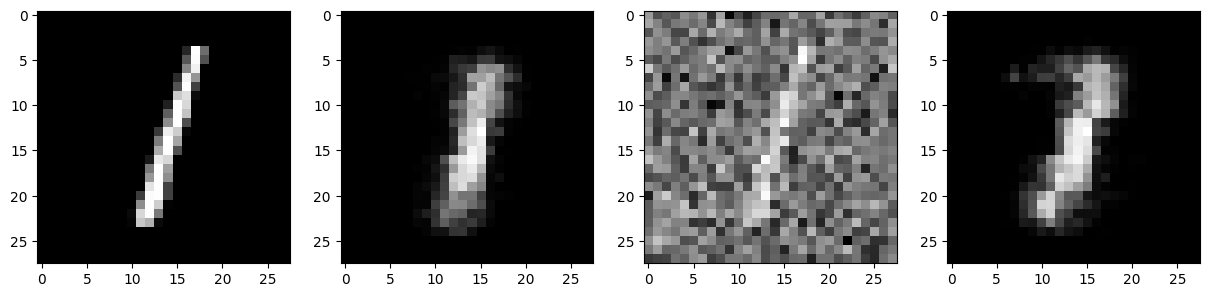

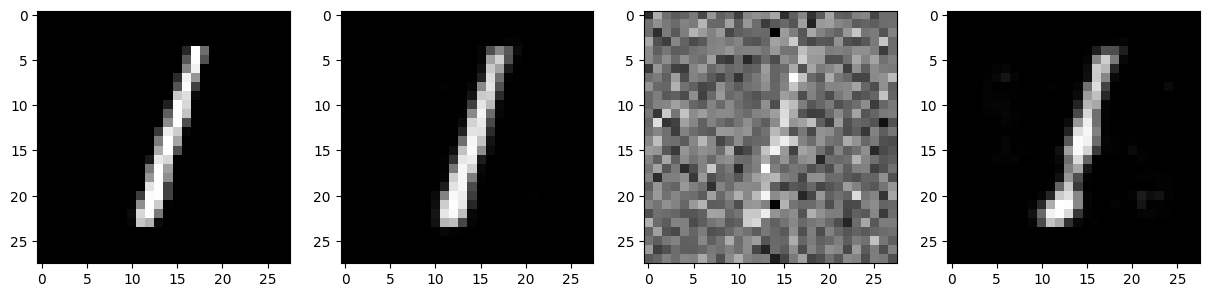

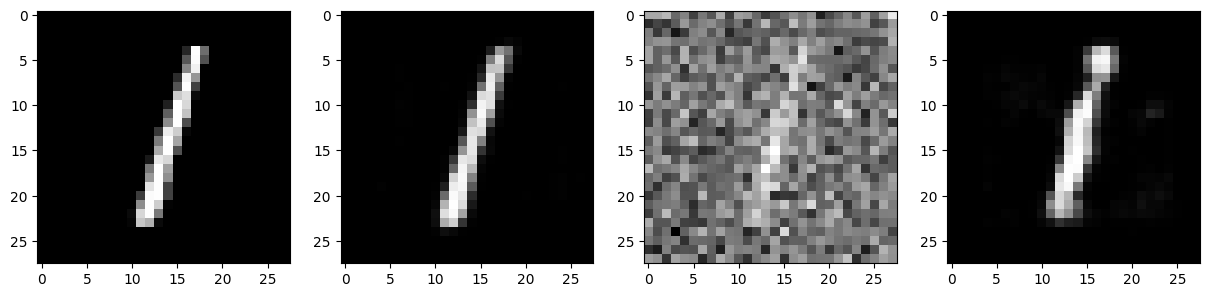

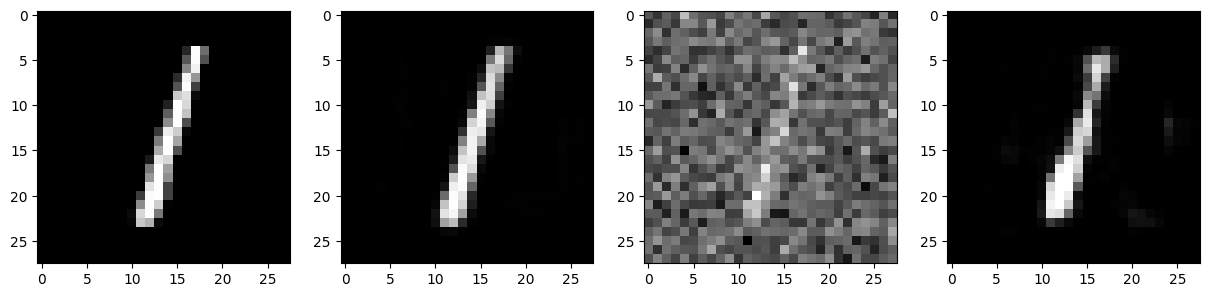

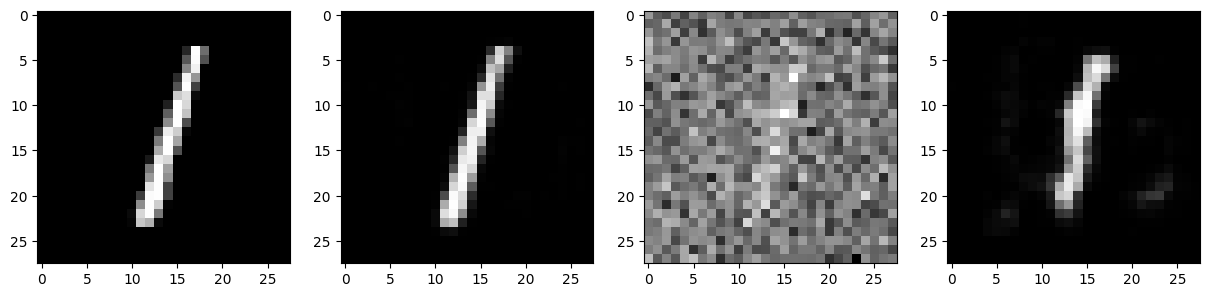

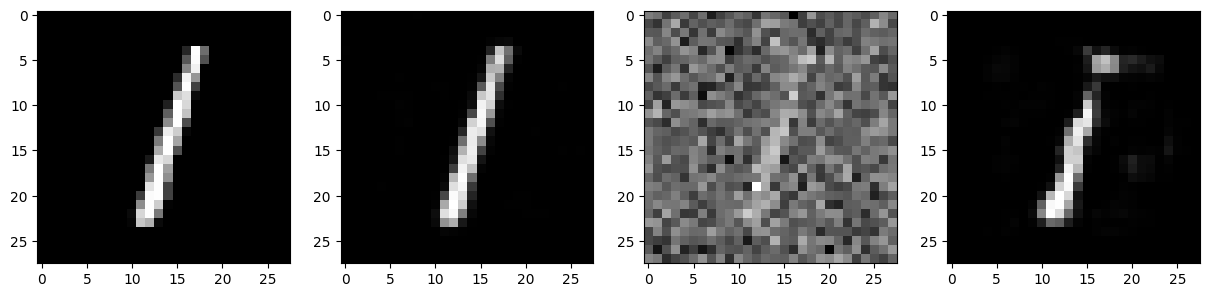

In [16]:
model_cae = train(config_cae, True)
save_model(model_cae, './models/cae.pt')

epoch [1/30], tr_loss: 0.0916, L1_val_loss: 0.2410, MSE_val_loss: 0.0898
epoch [2/30], tr_loss: 0.0559, L1_val_loss: 0.1849, MSE_val_loss: 0.0637
epoch [3/30], tr_loss: 0.0314, L1_val_loss: 0.0944, MSE_val_loss: 0.0334
epoch [4/30], tr_loss: 0.0216, L1_val_loss: 0.0714, MSE_val_loss: 0.0242
epoch [5/30], tr_loss: 0.0179, L1_val_loss: 0.0644, MSE_val_loss: 0.0211
epoch [6/30], tr_loss: 0.0158, L1_val_loss: 0.0571, MSE_val_loss: 0.0178
epoch [7/30], tr_loss: 0.0144, L1_val_loss: 0.0510, MSE_val_loss: 0.0143
epoch [8/30], tr_loss: 0.0134, L1_val_loss: 0.0479, MSE_val_loss: 0.0136
epoch [9/30], tr_loss: 0.0128, L1_val_loss: 0.0467, MSE_val_loss: 0.0130
epoch [10/30], tr_loss: 0.0122, L1_val_loss: 0.0425, MSE_val_loss: 0.0109
epoch [11/30], tr_loss: 0.0118, L1_val_loss: 0.0419, MSE_val_loss: 0.0107
epoch [12/30], tr_loss: 0.0114, L1_val_loss: 0.0410, MSE_val_loss: 0.0104
epoch [13/30], tr_loss: 0.0111, L1_val_loss: 0.0410, MSE_val_loss: 0.0102
epoch [14/30], tr_loss: 0.0108, L1_val_loss: 0.

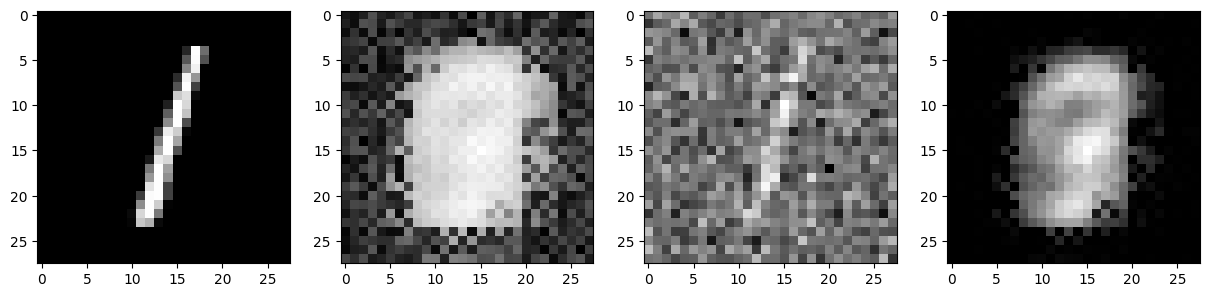

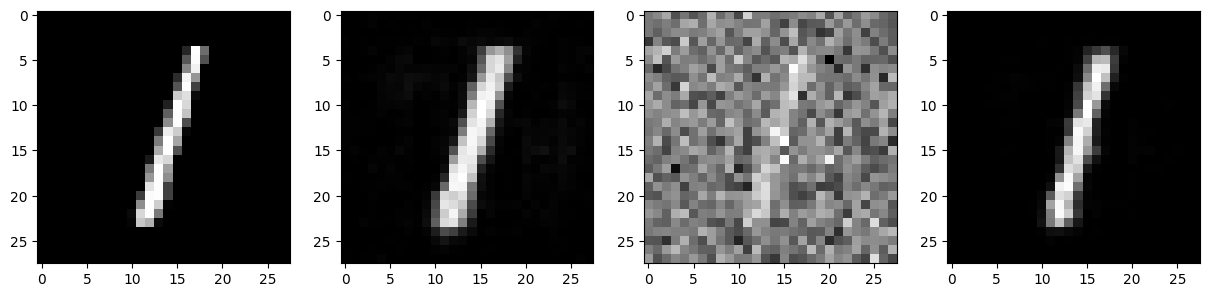

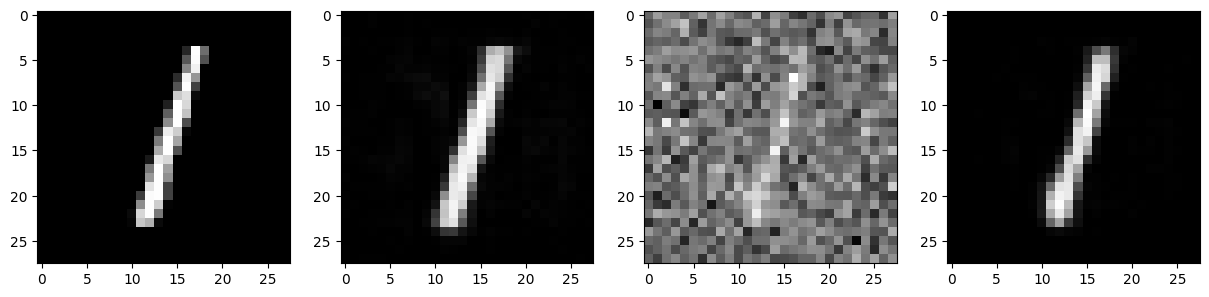

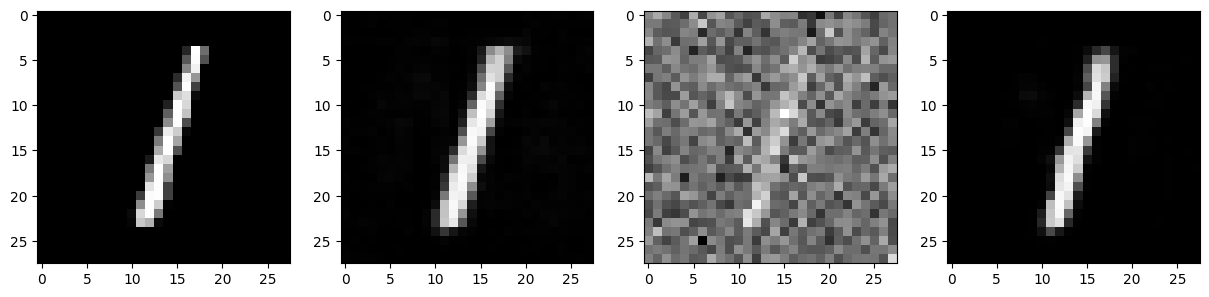

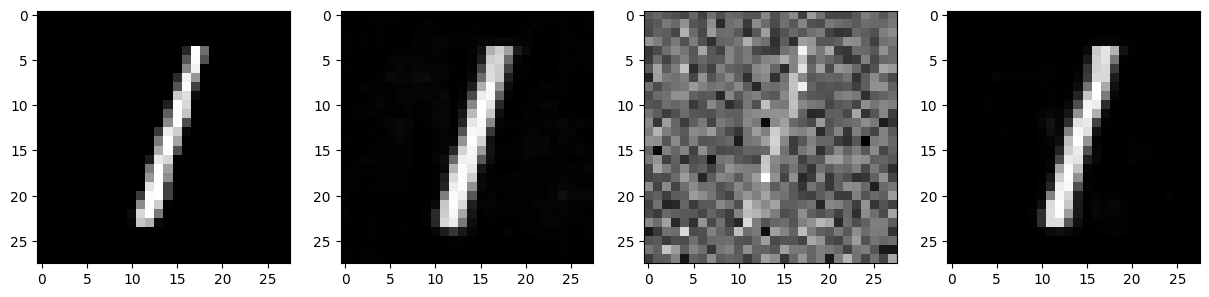

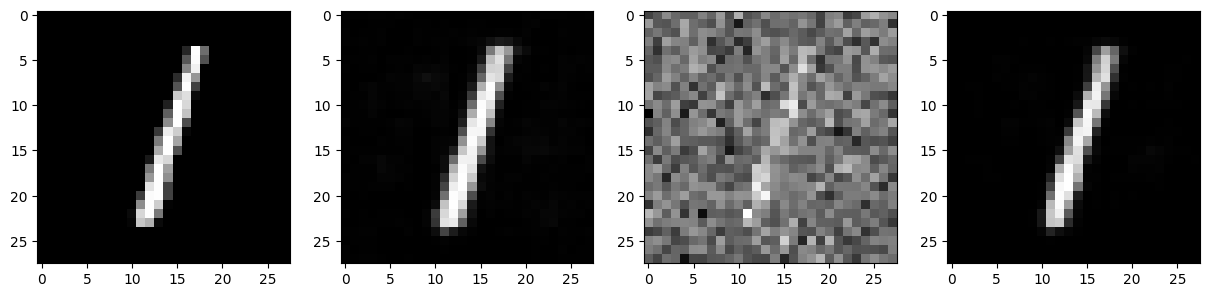

In [17]:
model_dae = train(config_dae, True)
save_model(model_dae, './models/dae.pt')

In [ ]:
'''wandb.agent('hltproject/ISPR_Assignment_3/v580ogbk', train)
wandb.finish()'''

## Accuracy Comparisons
Both model on noisy and original images

## Manifold Learning

In [10]:
model_cae = load_model('./models/cae.pt')
model_dae = load_model('./models/dae.pt')

model_cae.to(device)
model_dae.to(device)

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=3136, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [11]:
def manifold_convergence(model:nn.Module, max_iter:int = 100, seed:int = 100):
    gen = torch.Generator(device=device).manual_seed(seed)
    pure_rand_noise = torch.randn(torch.Size([1, 28, 28]), generator=gen, device=device)
    pure_rand_noise = pure_rand_noise.unsqueeze(0)

    model_cae.eval()
    with torch.no_grad():
        for i in range(max_iter):
            pure_rand_noise, _ = model(pure_rand_noise)

    pure_rand_noise = pure_rand_noise.squeeze(0).cpu()
    plt.imshow(pure_rand_noise.numpy()[0], cmap='gray')

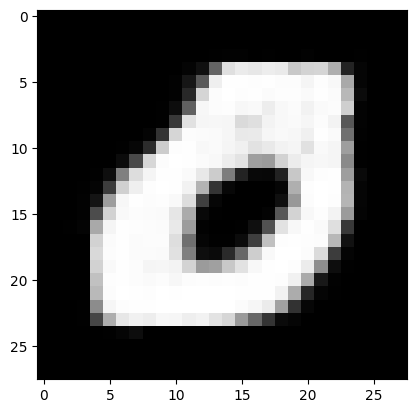

In [48]:
seed = 1234
manifold_convergence(model_dae, seed=seed)

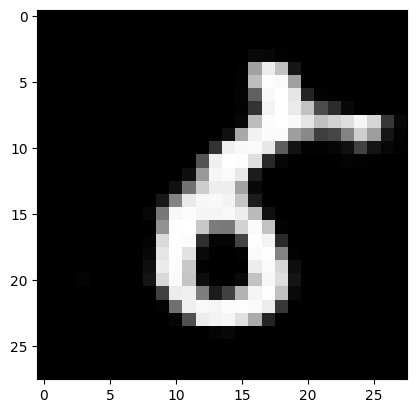

In [49]:
manifold_convergence(model_cae, seed=seed)